## Import the environment

In [212]:
import os, sys
import gymnasium as gym
import time
import numpy as np
import matplotlib.pyplot as plt
from utils import argmax
import tqdm
from collections import defaultdict
import pickle

import text_flappy_bird_gym

In [129]:
# Initiate environment
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
state, obs = env.reset()

## Monte Carlo based agent

In this first part, we implement an on-policy first-visit Monte Carlo agent.

The number of states corresponds to all the possible closest incoming pipe gap and bird positions on the grid, and the actions to "Flap" and "Not flap".

The `self.returns` dictionary contains the estimated returns of every (state, action) pair, while the `self.Q` matrix stores the estimated Q-values of the agent.

In [258]:
class MonteCarloAgent:
    """
    Monte Carlo based agent
    """
    def __init__(self, env, epsilon=0.1):
        self.env = env
        self.num_states_x, self.num_states_y = int(20 * 0.7), 24
        self.num_actions = env.action_space.n
        self.Q = np.zeros((self.num_states_x, self.num_states_y, self.num_actions))
        self.epsilon = epsilon
        self.gamma = 0.2
        self.returns = defaultdict(lambda: [])

    def epsilon_greedy_policy(self, state):
        """
        Usual epsilon-greedy policy
        """
        if np.random.random() < self.epsilon:
            return np.random.randint(self.num_actions)
        else:
            return argmax(self.Q[state])

    def train(self, n_episodes):
        """
        Train the agent for a given number of episodes by updating the Q-values matrix
        """
        train_reward = []
        for episode in tqdm.tqdm(range(n_episodes)):
            state, _ = self.env.reset()
            episode_states = []
            episode_actions = []
            episode_rewards = []

            while True:
                action = self.epsilon_greedy_policy(state)
                next_state, reward, done, _, _ = self.env.step(action)

                episode_states.append(state)
                episode_actions.append(action)
                episode_rewards.append(reward)

                if done:
                    break
                state = next_state
            train_reward.append(len(episode_rewards))

            G = 0
            for t in reversed(range(len(episode_states))):
                state_t = episode_states[t]
                action_t = episode_actions[t]
                reward_t = episode_rewards[t]

                G = self.gamma * G + reward_t

                if not (state, action) in zip(episode_states[:t], episode_actions[:t]):
                    self.returns[(state_t, action_t)] += [G]
                    self.Q[state_t][action_t] = np.mean(np.array(self.returns[(state_t, action_t)]))
        return train_reward

    def act(self, state):
        """
        Chose optimal move according to Q-values
        """
        return argmax(self.Q[state])

We can now train the agent for a given number of episodes, here 10,000.

In [259]:
# Create the Monte Carlo agent
mc_agent = MonteCarloAgent(env)

# Train the agent
mc_train_reward = mc_agent.train(n_episodes=10000)

100%|██████████| 10000/10000 [01:23<00:00, 120.11it/s]


Now, we can plot the reward evolution throughout the training.

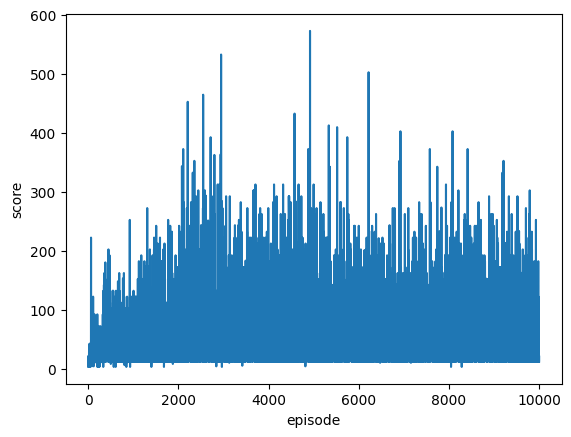

In [260]:
plt.plot(mc_train_reward)
plt.xlabel('episode')
plt.ylabel('score')
plt.show()

The curve being very noisy, we can take the mean reward every 100 episodes instead, to try and see a trend during training.

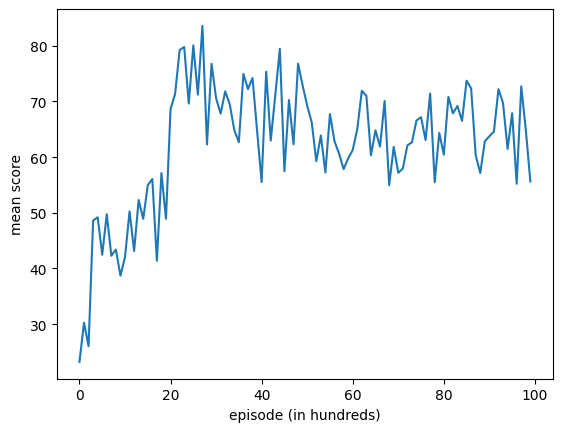

In [301]:
plt.plot(np.mean(np.array(mc_train_reward).reshape(-1, 100), axis=1))
plt.xlabel('episode (in hundreds)')
plt.ylabel('mean score')
plt.show()

Here, we play a game of Flappy Bird with the agent and display at each frame the critical distance between the bird and the next pipe gap, the corresponding Q-values and the chosen action (sanity check).

In [266]:
# Test the agent
state, info = env.reset()
total_reward = 0
done = False
while not done:
    action = mc_agent.act(state)
    print(state)
    print(mc_agent.Q[state])
    print(action)
    state, reward, done, _, info = env.step(action)
    total_reward += reward

print("Total reward:", total_reward)

(13, 3)
[1.24997674 1.25      ]
1
(12, 2)
[1.24980609 1.25      ]
1
(11, 1)
[1.24711538 1.25      ]
1
(10, 0)
[1.24799838 1.24999972]
1
(9, -1)
[1.24432767 1.24999949]
1
(8, -2)
[1.24998289 1.24999786]
1
(7, -3)
[1.24987464 1.24999735]
1
(6, -4)
[1.24989438 1.2499895 ]
1
(5, -4)
[1.24989797 1.24991955]
1
(4, -4)
[1.24947528 1.24979915]
1
(3, -4)
[1.24875878 1.24906768]
1
(2, -4)
[1.24696588 1.2       ]
0
(1, -3)
[1.23877721 1.        ]
0
(0, 0)
[1.12682621 1.24999409]
1
(9, -8)
[1.24999509 1.24999962]
1
(8, -9)
[1.24990474 1.24999908]
1
(7, -10)
[1.24999566 1.24998889]
0
(6, -9)
[1.24991192 1.24998279]
1
(5, -10)
[1.24991324 1.24979006]
0
(4, -9)
[1.24827338 1.24965625]
1
(3, -10)
[1.24871135 1.24      ]
0
(2, -9)
[1.2418213 1.2      ]
0
(1, -6)
[1.17022832 1.        ]
0
(0, -1)
[1.18826686 1.2499992 ]
1
(9, 5)
[1.23590176 1.24999328]
1
(8, 4)
[1.24688538 1.24999977]
1
(7, 3)
[1.24999411 1.24999914]
1
(6, 2)
[1.24850931 1.24999562]
1
(5, 1)
[1.239916   1.24998057]
1
(4, 0)
[1.24366664 

Same here, but we display at each frame the game state.

In [6]:
# Render the agent playing
state, info = env.reset()
total_reward = 0
done = False
while not done and total_reward < 200:
    action = mc_agent.act(state)
    print(mc_agent.Q[state])
    state, reward, done, _, info = env.step(action)
    total_reward += reward
    # Render the game
    os.system("clear")
    sys.stdout.write(env.render())
    time.sleep(0.2) # FPS

env.close()
print("Total reward:", total_reward)

[1.24996364 1.25      ]
Text Flappy Bird!
Score: 0
----------------------
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                    ]
[                    ]
[      @             ]
[                    ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=12,dy=0)
[1.2498969  1.24999996]
Text Flappy Bird!
Score: 0
----------------------
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                    ]
[      @             ]
[                    ]
[                    ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=11,dy=-1)
[1.245352

Here, we display the Q-values of the agent on a 2D plot. Please see the report for an analysis.

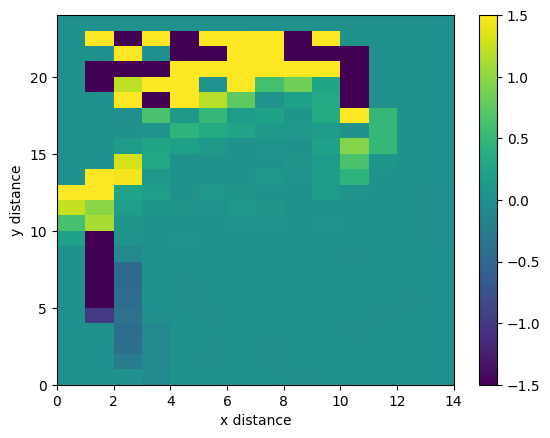

In [296]:
Q_matrix = np.transpose(mc_agent.Q[:, :, 1] - mc_agent.Q[:, :, 0])
fig = plt.figure()
ax = fig.add_subplot(111)
pc = ax.pcolormesh(np.concatenate((Q_matrix[13:], Q_matrix[:13]))*10, vmin=-1.5, vmax=1.5)
ax.set_xlabel('x distance')
ax.set_ylabel('y distance')
fig.colorbar(pc)
plt.show()

In [305]:
def compute_mean_score(agent, env, n_episodes):
    scores = []
    for episode in tqdm.tqdm(range(n_episodes)):
        state, info = env.reset()
        total_reward = 0
        done = False
        while not done:
            action = agent.act(state)
            state, reward, done, _, info = env.step(action)
            total_reward += reward
        scores.append(total_reward)
    return np.array(scores).mean()

In [306]:
mc_mean_score = compute_mean_score(mc_agent, mc_agent.env, 1000)
print(f'Monte Carlo agent mean score: {mc_mean_score}')

100%|██████████| 1000/1000 [00:05<00:00, 188.40it/s]

347.84


## Sarsa agent

Now, we implement the Sarsa agent.

Again, the number of states corresponds to all possible configurations for the critical distance.

The `self.alpha` parameter is the agent's learning rate and `self.gamma` is the discount rate, while the `self.Q` matrix stores the estimated Q-values of the agent.

In [186]:
class SarsaAgent:
    """
    State-action-reward-state-action agent
    """
    def __init__(self, env, alpha=0.5, gamma=0.5, epsilon=0.1):
        self.env = env
        self.num_states_x, self.num_states_y = int(20 * 0.7), 24
        self.num_actions = env.action_space.n
        self.Q = np.zeros((self.num_states_x, self.num_states_y, self.num_actions))
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

    def epsilon_greedy_policy(self, state):
        """
        Usual epsilon-greedy policy
        """
        if np.random.random() < self.epsilon:
            return np.random.randint(self.num_actions)
        else:
            return argmax(self.Q[state])

    def train(self, n_episodes):
        """
        Train the agent for a given number of episodes by updating the Q-values matrix
        """
        train_reward = []
        for episode in tqdm.tqdm(range(n_episodes)):
            state, _ = self.env.reset()
            action = self.epsilon_greedy_policy(state)
            episode_reward = 0

            while True:
                next_state, reward, done, _, _ = self.env.step(action)
                next_action = self.epsilon_greedy_policy(next_state)
                episode_reward += reward

                self.Q[state][action] += self.alpha * (reward + self.gamma * self.Q[next_state][next_action] - self.Q[state][action])

                if done:
                    break

                state = next_state
                action = next_action
            train_reward.append(episode_reward)
        return(train_reward)

    def act(self, state):
        """
        Chose optimal move according to Q-values
        """
        return argmax(self.Q[state])

We now train the agent on around 20,000 episodes.

In [187]:
# Create the Sarsa agent
sarsa_agent = SarsaAgent(env)

# Train the agent
sarsa_train_reward = sarsa_agent.train(n_episodes=20000)

100%|██████████| 20000/20000 [00:20<00:00, 983.81it/s] 


Same as earlier, we plot the evolution of each episode's total score during training

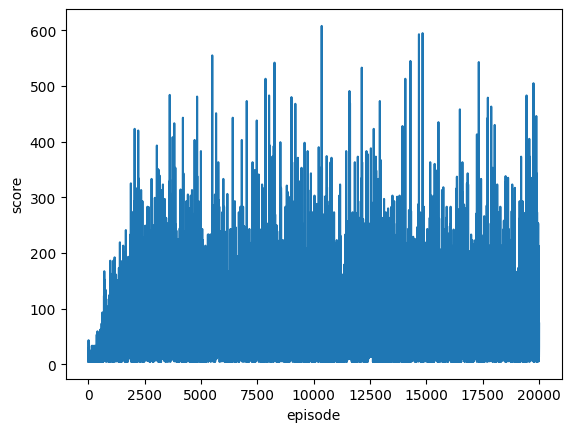

In [271]:
plt.plot(sarsa_train_reward)
plt.xlabel('episode')
plt.ylabel('score')
plt.show()

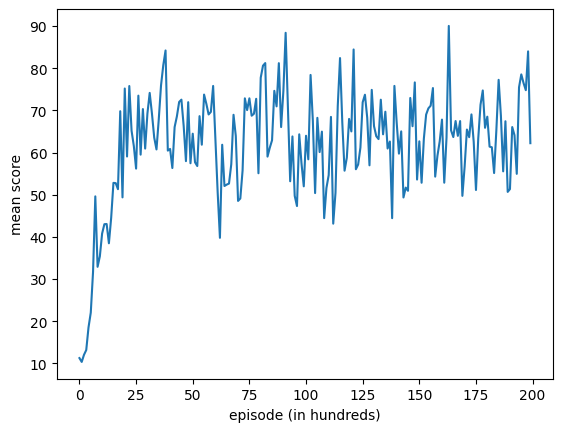

In [302]:
plt.plot(np.mean(np.array(sarsa_train_reward).reshape(-1, 100), axis=1))
plt.xlabel('episode (in hundreds)')
plt.ylabel('mean score')
plt.show()

Same sanity check as before, we see that it reaches much higher scores.

In [300]:
# Test the agent
state, info = env.reset()
total_reward = 0
done = False
while not done:
    action = sarsa_agent.act(state)
    print(state)
    print(sarsa_agent.Q[state])
    print(action)
    state, reward, done, _, info = env.step(action)
    total_reward += reward

print("Total reward:", total_reward)

(13, -2)
[1.99973281 1.99997744]
1
(12, -3)
[1.99995463 1.99995751]
1
(11, -4)
[1.99992362 1.99964813]
0
(10, -3)
[1.99984845 1.99982331]
0
(9, 0)
[1.99936614 1.99961022]
1
(8, -1)
[1.99896542 1.99934286]
1
(7, -2)
[1.99745274 1.99882266]
1
(6, -3)
[1.9974274  1.99614168]
0
(5, -2)
[1.97302447 1.9936162 ]
1
(4, -3)
[1.99102223 1.96826302]
0
(3, -2)
[1.90851217 1.99455969]
1
(2, -3)
[1.99970633 1.62769241]
0
(1, -2)
[1.99989885 1.        ]
0
(0, 1)
[1.99930119 1.99958085]
1
(9, 4)
[1.99894757 1.99964765]
1
(8, 3)
[1.99843594 1.99940719]
1
(7, 2)
[1.99769423 1.99781643]
1
(6, 1)
[1.99558915 1.99831673]
1
(5, 0)
[1.99552376 1.99753283]
1
(4, -1)
[1.95455287 1.97301065]
1
(3, -2)
[1.90851217 1.99455969]
1
(2, -3)
[1.99970633 1.62769241]
0
(1, -2)
[1.99989885 1.        ]
0
(0, 1)
[1.99930119 1.99958085]
1
(9, -4)
[1.99968255 1.9996869 ]
1
(8, -5)
[1.99872689 1.99945665]
1
(7, -6)
[1.99866295 1.99831575]
0
(6, -5)
[1.99657346 1.99537943]
0
(5, -2)
[1.97302447 1.9936162 ]
1
(4, -3)
[1.9910222

Same game render as before, only this time it can take much longer if the game keeps going on.

In [209]:
# Render the agent playing
state, info = env.reset()
total_reward = 0
done = False
while not done and total_reward < 200:
    action = sarsa_agent.act(state)
    print(sarsa_agent.Q[state])
    state, reward, done, _, info = env.step(action)
    total_reward += reward
    # Render the game
    os.system("clear")
    sys.stdout.write(env.render())
    time.sleep(0.2) # FPS

env.close()
print("Total reward:", total_reward)

[1.98855261 1.99997921]
Text Flappy Bird!
Score: 0
----------------------
[                  | ]
[                    ]
[                    ]
[                    ]
[                    ]
[                  | ]
[      @           | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=12,dy=3)
[1.99554593 1.99996758]
Text Flappy Bird!
Score: 0
----------------------
[                 |  ]
[                    ]
[                    ]
[                    ]
[                    ]
[      @          |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=11,dy=2)
[1.9998783

Same plot as earlier for the Sarsa agent, please see the report.

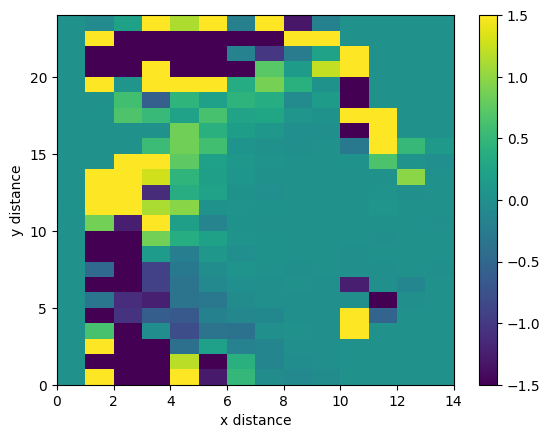

In [297]:
Q_matrix = np.transpose(sarsa_agent.Q[:, :, 1] - sarsa_agent.Q[:, :, 0])
fig = plt.figure()
ax = fig.add_subplot(111)
pc = ax.pcolormesh(np.concatenate((Q_matrix[13:], Q_matrix[:13]))*10, vmin=-1.5, vmax=1.5)
ax.set_xlabel('x distance')
ax.set_ylabel('y distance')
fig.colorbar(pc)
plt.show()

In [197]:
sarsa_mean_score = compute_mean_score(sarsa_agent, sarsa_agent.env, 100)
print(f'Sarsa agent mean score: {sarsa_mean_score}')

100%|██████████| 100/100 [00:15<00:00,  6.62it/s]

9479.2


Now let's try to apply our best performing agent, trained to a 15 squares high, 20 squares wide and 4 squares tall pipe gaps environment, to another level configuration.

In [303]:
with open('sarsa_agent.pkl', 'rb') as inp:
    sarsa_agent = pickle.load(inp)

In [318]:
print('Smaller pipe gaps')
env_different = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=3)
mc_mean_score_different = compute_mean_score(sarsa_agent, env_different, 100)
print(f'Monte carlo agent: {mc_mean_score_different}')
sarsa_mean_score_different = compute_mean_score(sarsa_agent, env_different, 100)
print(f'Sarsa agent: {sarsa_mean_score_different}')

Smaller pipe gaps


100%|██████████| 100/100 [00:00<00:00, 1576.03it/s]


Monte carlo agent: 35.92


100%|██████████| 100/100 [00:00<00:00, 1869.67it/s]

Sarsa agent: 30.81


In [319]:
print('Less wide level')
env_different = gym.make('TextFlappyBird-v0', height=15, width=12, pipe_gap=3)
mc_mean_score_different = compute_mean_score(sarsa_agent, env_different, 100)
print(f'Monte carlo agent: {mc_mean_score_different}')
sarsa_mean_score_different = compute_mean_score(sarsa_agent, env_different, 100)
print(f'Sarsa agent: {sarsa_mean_score_different}')

Less wide level


100%|██████████| 100/100 [00:00<00:00, 2710.57it/s]


Monte carlo agent: 19.85


100%|██████████| 100/100 [00:00<00:00, 2333.11it/s]

Sarsa agent: 22.38


In [320]:
print('Taller level')
env_different = gym.make('TextFlappyBird-v0', height=20, width=20, pipe_gap=3)
mc_mean_score_different = compute_mean_score(sarsa_agent, env_different, 100)
print(f'Monte carlo agent: {mc_mean_score_different}')
sarsa_mean_score_different = compute_mean_score(sarsa_agent, env_different, 100)
print(f'Sarsa agent: {sarsa_mean_score_different}')

Taller level


100%|██████████| 100/100 [00:00<00:00, 1805.87it/s]


Monte carlo agent: 29.61


100%|██████████| 100/100 [00:00<00:00, 1847.58it/s]

Sarsa agent: 32.81
